<a href="https://colab.research.google.com/github/imatyushov/math-stat-hse-itmo/blob/main/lab_13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from scipy.optimize import minimize
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
a_true = np.array([0.0, 1.0, 1.0])
x_values = np.linspace(0.1, 3.0, 30)
N = 1000
sigma = 0.05

def f(x, a):
    return (a[1] * x + a[0]) / (x + a[2])

def generate_noise(dist, size):
    if dist == "normal":
        return np.random.normal(0, sigma, size)
    elif dist == "uniform":
        scale = np.sqrt(3) * sigma
        return np.random.uniform(-scale, scale, size)
    elif dist == "laplace":
        lambda_laplace = np.sqrt(2) / sigma
        return np.random.laplace(0, 1 / lambda_laplace, size)

data = {"normal": [], "uniform": [], "laplace": []}
for dist in data.keys():
    for _ in range(N):
        noise = generate_noise(dist, len(x_values))
        y_values = f(x_values, a_true) + noise
        data[dist].append(y_values)


In [3]:
def ols_fit(x, y):
    def residuals(a):
        return np.sum((y - f(x, a)) ** 2)
    res = minimize(residuals, a_true)
    return res.x

def l1_fit(x, y):
    def residuals(a):
        return np.sum(np.abs(y - f(x, a)))
    res = minimize(residuals, a_true)
    return res.x

def minimax_fit(x, y):
    def residuals(a):
        return np.max(np.abs(y - f(x, a)))
    res = minimize(residuals, a_true)
    return res.x


In [4]:
def check_significance(x, y, a_fit):
    x_design = sm.add_constant(x)
    y_pred = f(x, a_fit)
    model = sm.OLS(y, x_design).fit()
    p_values = model.pvalues
    f_pvalue = model.f_pvalue
    return p_values, f_pvalue

In [5]:
results = {"normal": {"ols": [], "l1": [], "minimax": []},
           "uniform": {"ols": [], "l1": [], "minimax": []},
           "laplace": {"ols": [], "l1": [], "minimax": []}}

for dist, datasets in data.items():
    for y_values in datasets:
        ols_params = ols_fit(x_values, y_values)
        l1_params = l1_fit(x_values, y_values)
        minimax_params = minimax_fit(x_values, y_values)

        p_values, f_pvalue = check_significance(x_values, y_values, ols_params)
        significant_coeffs = (p_values < 0.05).sum()
        model_adequate = f_pvalue < 0.05

        results[dist]["ols"].append((significant_coeffs == len(a_true), model_adequate))

for dist, res in results.items():
    ols_significant = np.mean([x[0] for x in res["ols"]])
    ols_adequate = np.mean([x[1] for x in res["ols"]])
    print(f"Распределение: {dist}")
    print(f"\tOLS: Доля незначимых коэффициентов = {ols_significant:.2f}, адекватность модели = {ols_adequate:.2f}")

Распределение: normal
	OLS: Доля незначимых коэффициентов = 0.00, адекватность модели = 1.00
Распределение: uniform
	OLS: Доля незначимых коэффициентов = 0.00, адекватность модели = 1.00
Распределение: laplace
	OLS: Доля незначимых коэффициентов = 0.00, адекватность модели = 1.00


In [6]:
from scipy.stats import norm

def confidence_interval(successes, total, confidence=0.95):
    p = successes / total
    z = norm.ppf(1 - (1 - confidence) / 2)
    error_margin = z * np.sqrt(p * (1 - p) / total)
    return p - error_margin, p + error_margin

confidence = 0.95
for dist, res in results.items():
    ols_significant = np.mean([x[0] for x in res["ols"]])
    ols_adequate = np.mean([x[1] for x in res["ols"]])

    ci_significant = confidence_interval(np.sum([x[0] for x in res["ols"]]), N, confidence)
    ci_adequate = confidence_interval(np.sum([x[1] for x in res["ols"]]), N, confidence)

    print(f"Распределение: {dist}")
    print(f"\tOLS: Доля значимых коэффициентов = {ols_significant:.2f} ({ci_significant[0]:.2f}, {ci_significant[1]:.2f})")
    print(f"\tOLS: Доля адекватности модели = {ols_adequate:.2f} ({ci_adequate[0]:.2f}, {ci_adequate[1]:.2f})")


Распределение: normal
	OLS: Доля значимых коэффициентов = 0.00 (0.00, 0.00)
	OLS: Доля адекватности модели = 1.00 (1.00, 1.00)
Распределение: uniform
	OLS: Доля значимых коэффициентов = 0.00 (0.00, 0.00)
	OLS: Доля адекватности модели = 1.00 (1.00, 1.00)
Распределение: laplace
	OLS: Доля значимых коэффициентов = 0.00 (0.00, 0.00)
	OLS: Доля адекватности модели = 1.00 (1.00, 1.00)


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import laplace
import numpy.linalg as la

# Parameters
N = 10**3  # Number of datasets
x = np.arange(0.1, 3.1, 0.1)
a0 = 0.0
a1 = 1.0
a2 = 1.0

def f(x, a0, a1, a2):
    """The Regression function"""
    return (a1 * x + a0) / (x + a2)

sigma = 0.05
lambda_laplace = np.sqrt(2) / sigma


datasets = {
    "normal_distribution": [],
    "uniform_distribution": [],
    "laplace_distribution": [],
}

for _ in range(N):
    #Normal distribution
    epsilon = np.random.normal(0, sigma, len(x))
    y_normal = f(x, a0, a1, a2) + epsilon
    datasets["normal_distribution"].append((x, y_normal))

    #Uniform distribution
    epsilon = np.random.uniform(-np.sqrt(3) * sigma, np.sqrt(3) * sigma, len(x))
    y_uniform = f(x, a0, a1, a2) + epsilon
    datasets["uniform_distribution"].append((x, y_uniform))

    #Laplace distribution
    epsilon = np.random.laplace(0, 1/lambda_laplace, len(x))
    y_laplace = f(x, a0, a1, a2) + epsilon
    datasets["laplace_distribution"].append((x, y_laplace))

In [5]:
def ols_regression(x, y):
    """Ordinary Least Squares regression."""
    X = np.vstack((x, np.ones(len(x)), x**2)).T  # Construct the design matrix
    try:
        params = la.solve(X.T @ X, X.T @ y) # Solving for a0, a1, a2 parameters using linear algebra
        return params
    except la.LinAlgError:
        return None # Return None if matrix is not invertible


def lad_regression(x, y):
    """Least Absolute Deviations regression."""
    def objective(params):
        a0, a1, a2 = params
        return np.sum(np.abs(y - f(x, a0, a1, a2)))

    initial_params = [a0, a1, a2]
    result = minimize(objective, initial_params)
    return result.x

def minimax_regression(x, y):
    """Minimax regression."""
    def objective(params):
        a0, a1, a2 = params
        return np.max(np.abs(y - f(x, a0, a1, a2)))

    initial_params = [a0, a1, a2]
    result = minimize(objective, initial_params)
    return result.x

regression_results = {
    "normal_distribution": {
      "ols": [],
      "lad": [],
      "minimax": []
      },
    "uniform_distribution":{
      "ols": [],
      "lad": [],
      "minimax": []
      },
    "laplace_distribution":{
      "ols": [],
      "lad": [],
       "minimax": []
      }
}

for dist_name, data in datasets.items():
    for x_vals, y_vals in data:
            #OLS regression
            params = ols_regression(x_vals, y_vals)
            regression_results[dist_name]["ols"].append(params)
            #LAD regression
            params = lad_regression(x_vals, y_vals)
            regression_results[dist_name]["lad"].append(params)
            #Minimax regression
            params = minimax_regression(x_vals, y_vals)
            regression_results[dist_name]["minimax"].append(params)

In [3]:
from scipy.stats import t, f
import math

def ols_regression(x, y):
    """Ordinary Least Squares regression and test of significance."""
    X = np.vstack((x, np.ones(len(x)), x**2)).T  # Design matrix
    try:
        params = la.solve(X.T @ X, X.T @ y)  # Solve for parameters
        y_predicted = X @ params #Predicted y values

        #Residual sum of squares
        rss = np.sum((y - y_predicted) ** 2)

        #Variance of the error terms
        n = len(x)
        p = 3 #Number of parameters in our regression
        mse = rss/(n - p)

        #Covariance matrix of parameter estimates
        cov_params = np.linalg.inv(X.T @ X) * mse

        #Standard errors of the parameters
        se_a0 = np.sqrt(cov_params[1, 1])
        se_a1 = np.sqrt(cov_params[0, 0])
        se_a2 = np.sqrt(cov_params[2, 2])

        #T-statistics
        t_a0 = params[1] / se_a0
        t_a1 = params[0] / se_a1
        t_a2 = params[2] / se_a2

        #P-values
        p_a0 = 2 * (1 - t.cdf(np.abs(t_a0), n - p))
        p_a1 = 2 * (1 - t.cdf(np.abs(t_a1), n - p))
        p_a2 = 2 * (1 - t.cdf(np.abs(t_a2), n - p))


        return params, p_a0, p_a1, p_a2, mse, y_predicted

    except la.LinAlgError:
        return None, None, None, None, None, None


def adequacy_test(y, y_predicted, mse, alpha):
    """Tests the model adequacy"""
    n = len(y)
    p = 3 #Number of parameters in the model

    # Sum of squares of the residuals
    rss = np.sum((y - y_predicted)**2)

    # Degree of freedom for the error
    df_error = n - p

    # Mean squared error
    mse_error = rss/df_error

    #Test statistic
    f_statistic = mse/mse_error

    #P-value
    p_value = 1 - f.cdf(f_statistic, n - 1, df_error)

    #Adequacy test based on given alpha level
    return p_value < alpha


regression_results = {
    "normal_distribution": {
      "insignificant_coef_count": [0, 0, 0], #a0, a1, a2 counts respectively
       "inadequate_model_count": 0
      },
    "uniform_distribution":{
      "insignificant_coef_count": [0, 0, 0],
      "inadequate_model_count": 0
      },
    "laplace_distribution":{
      "insignificant_coef_count": [0, 0, 0],
      "inadequate_model_count": 0
      }
}

alpha = 0.05

for dist_name, data in datasets.items():
    for x_vals, y_vals in data:
        #OLS Regression
        params, p_a0, p_a1, p_a2, mse, y_predicted = ols_regression(x_vals, y_vals)

        if params is not None: #Check if linear algebra solve worked

            #Insignificant coefficient counts
            if p_a0 is not None and p_a0 > alpha:
                regression_results[dist_name]["insignificant_coef_count"][0] += 1 #increment a0 counter

            if p_a1 is not None and p_a1 > alpha:
               regression_results[dist_name]["insignificant_coef_count"][1] += 1 #increment a1 counter

            if p_a2 is not None and p_a2 > alpha:
               regression_results[dist_name]["insignificant_coef_count"][2] += 1 #increment a2 counter

            #Adequacy test
            if y_predicted is not None and mse is not None and adequacy_test(y_vals, y_predicted, mse, alpha):
                regression_results[dist_name]["inadequate_model_count"] += 1

#Calculate results and confidence intervals
confidence_intervals = {}
for dist_name, result in regression_results.items():
    confidence_intervals[dist_name] = {}
    total_samples = N
    for i, count in enumerate(result["insignificant_coef_count"]): #coef results
        p_hat = count / total_samples
        se = np.sqrt((p_hat * (1 - p_hat)) / total_samples) #Standard Error
        lower_bound = max(0, p_hat - 1.96 * se)
        upper_bound = min(1, p_hat + 1.96 * se)
        confidence_intervals[dist_name][f'a{i}']= (lower_bound, upper_bound)

    p_hat = result["inadequate_model_count"] / total_samples
    se = np.sqrt((p_hat * (1 - p_hat)) / total_samples) #Standard Error
    lower_bound = max(0, p_hat - 1.96 * se)
    upper_bound = min(1, p_hat + 1.96 * se)
    confidence_intervals[dist_name]['inadequate_model'] = (lower_bound, upper_bound)


# Result print
for dist_name, result in confidence_intervals.items():
    print(f"\nResults for {dist_name}:")
    for coef_name, ci in result.items():
        print(f"   {coef_name}: {ci}")


Results for normal_distribution:
   a0: (0.07135139987421098, 0.10664860012578901)
   a1: (0, 0.0)
   a2: (0, 0.0)
   inadequate_model: (0, 0.0)

Results for uniform_distribution:
   a0: (0.07957224719071802, 0.11642775280928198)
   a1: (0, 0.0)
   a2: (0, 0.0)
   inadequate_model: (0, 0.0)

Results for laplace_distribution:
   a0: (0.08048873644507215, 0.11751126355492786)
   a1: (0, 0.0)
   a2: (0, 0.0)
   inadequate_model: (0, 0.0)


3 variant


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import laplace, t, f
import numpy.linalg as la

# Parameters
N = 10**3  # Number of datasets
x = np.arange(0.1, 3.1, 0.1)
a0 = 0.0
a1 = 1.0
a2 = 1.0

def f(x, a0, a1, a2):
    """The regression function."""
    return (a1 * x + a0) / (x + a2)

sigma = 0.05
lambda_laplace = np.sqrt(2) / sigma


datasets = {
    "normal_distribution": [],
    "uniform_distribution": [],
    "laplace_distribution": [],
}

for _ in range(N):
    #Normal distribution
    epsilon = np.random.normal(0, sigma, len(x))
    y_normal = f(x, a0, a1, a2) + epsilon
    datasets["normal_distribution"].append((x, y_normal))

    #Uniform distribution
    epsilon = np.random.uniform(-np.sqrt(3) * sigma, np.sqrt(3) * sigma, len(x))
    y_uniform = f(x, a0, a1, a2) + epsilon
    datasets["uniform_distribution"].append((x, y_uniform))

    #Laplace distribution
    epsilon = np.random.laplace(0, 1/lambda_laplace, len(x))
    y_laplace = f(x, a0, a1, a2) + epsilon
    datasets["laplace_distribution"].append((x, y_laplace))


Results for normal_distribution:
   a0: (0.08876242277208483, 0.12723757722791518)
   a1: (0, 0.0)
   a2: (0, 0.0)
   inadequate_model: (0, 0.0)

Results for uniform_distribution:
   a0: (0.073173802693788, 0.108826197306212)
   a1: (0, 0.0)
   a2: (0, 0.0)
   inadequate_model: (0, 0.0)

Results for laplace_distribution:
   a0: (0.07865634753927125, 0.11534365246072875)
   a1: (0, 0.0)
   a2: (0, 0.0)
   inadequate_model: (0, 0.0)


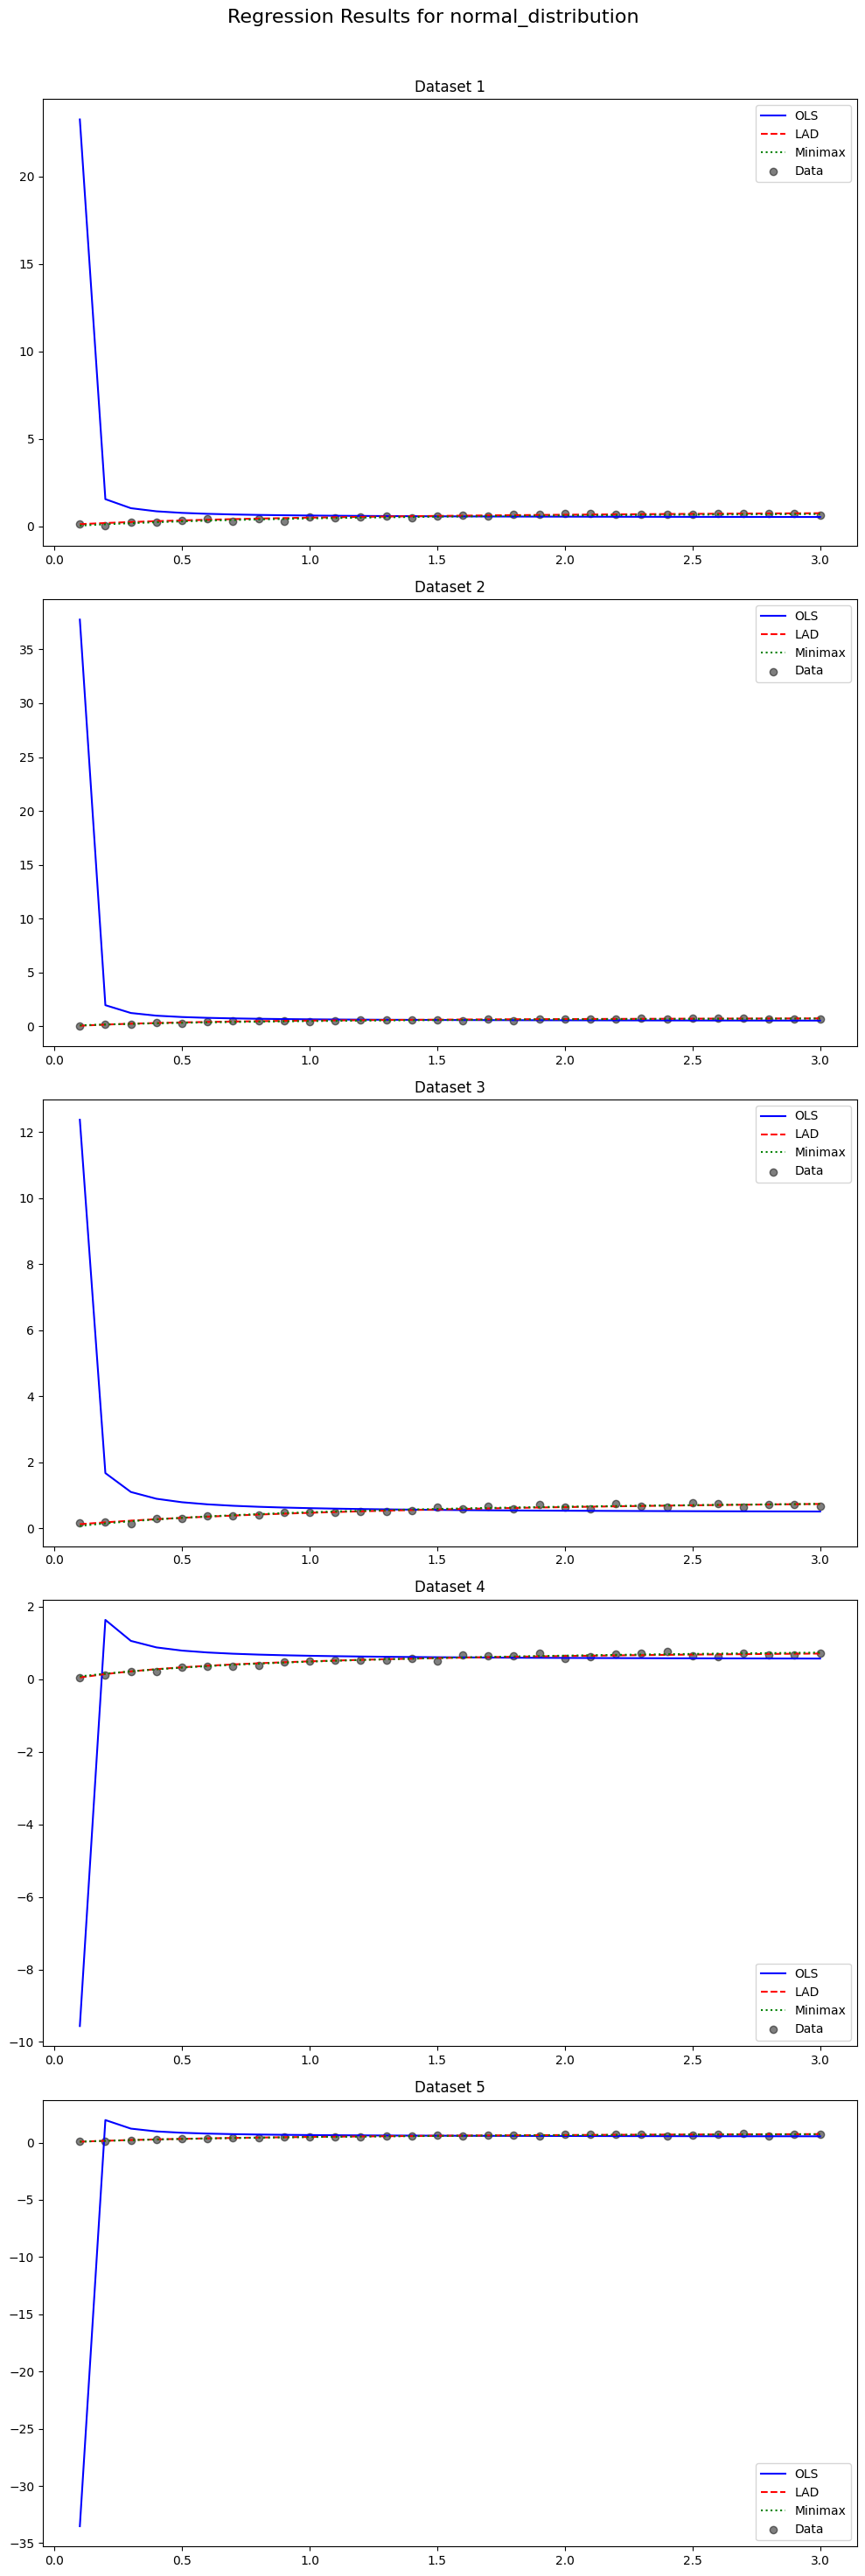

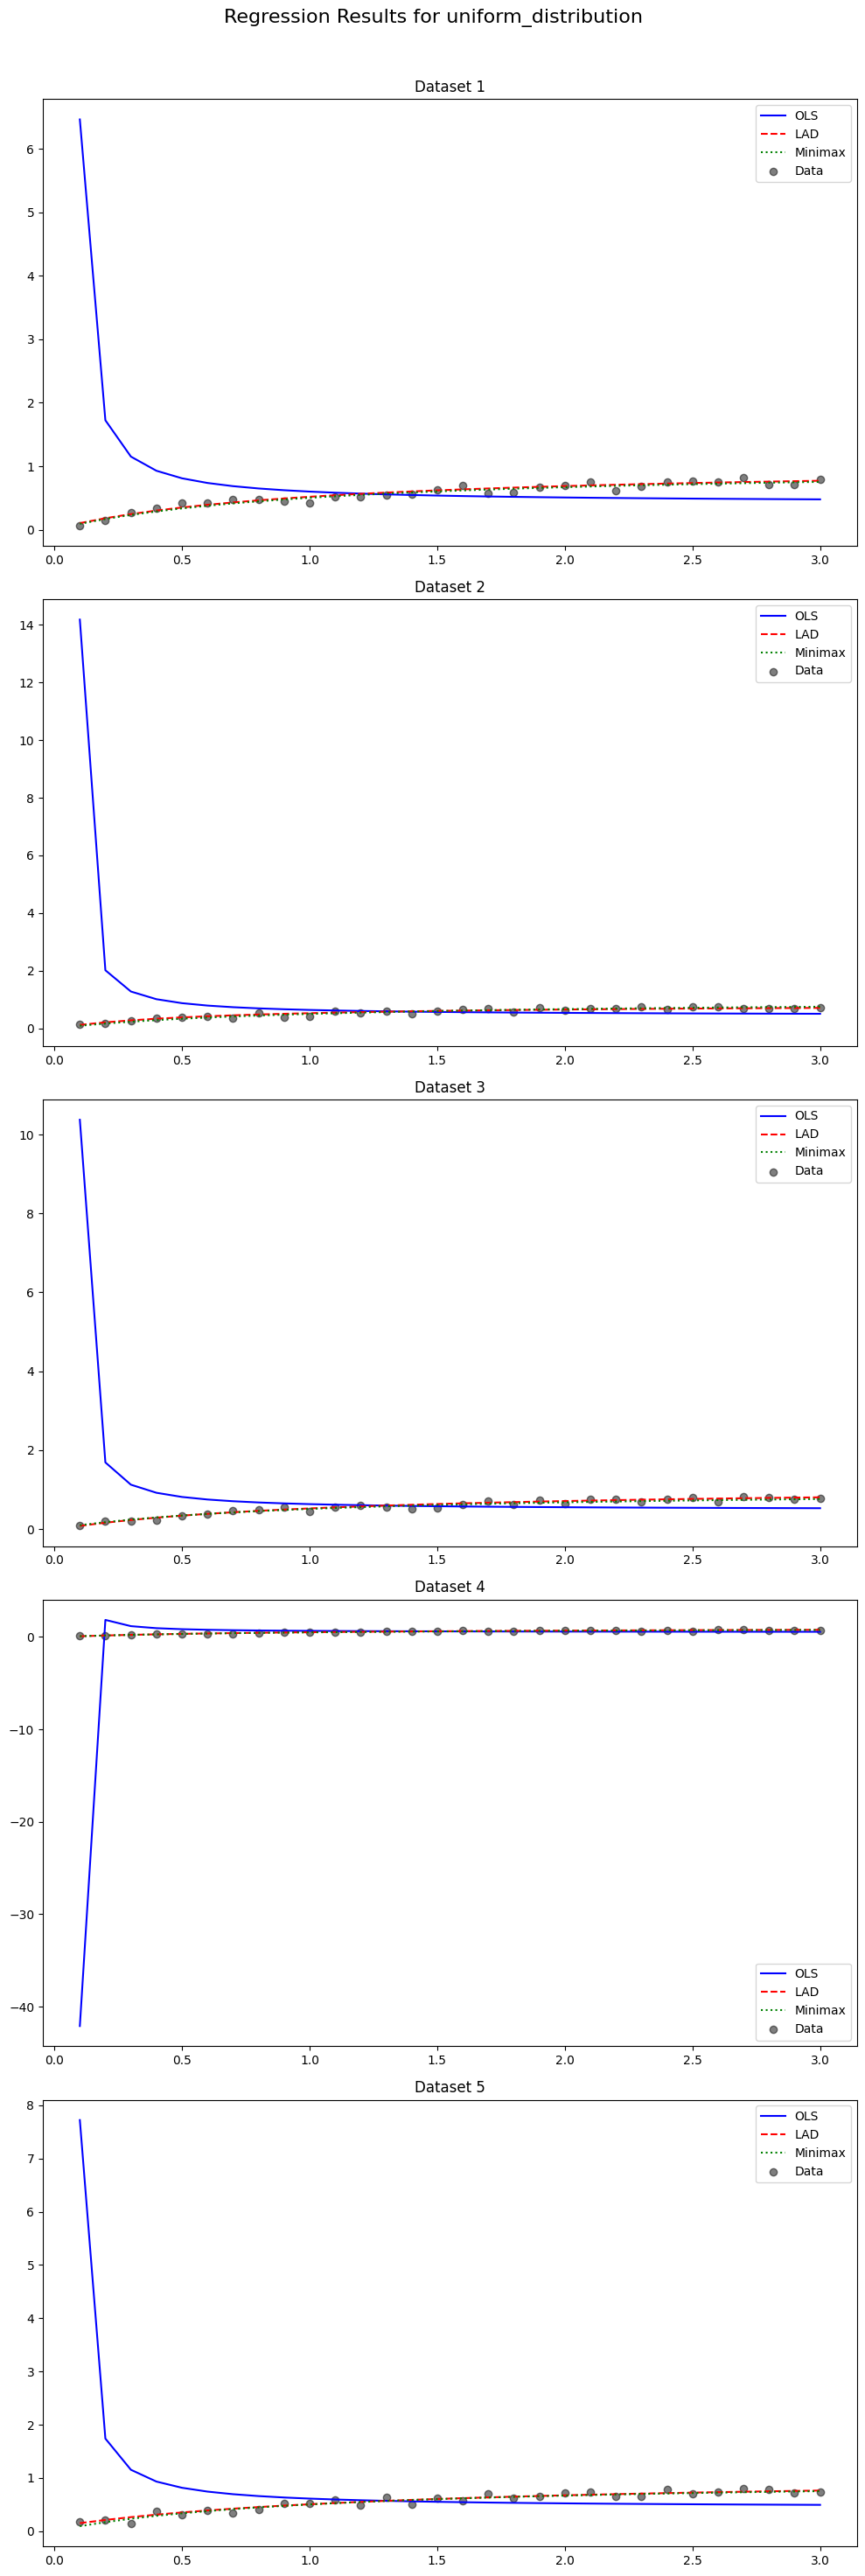

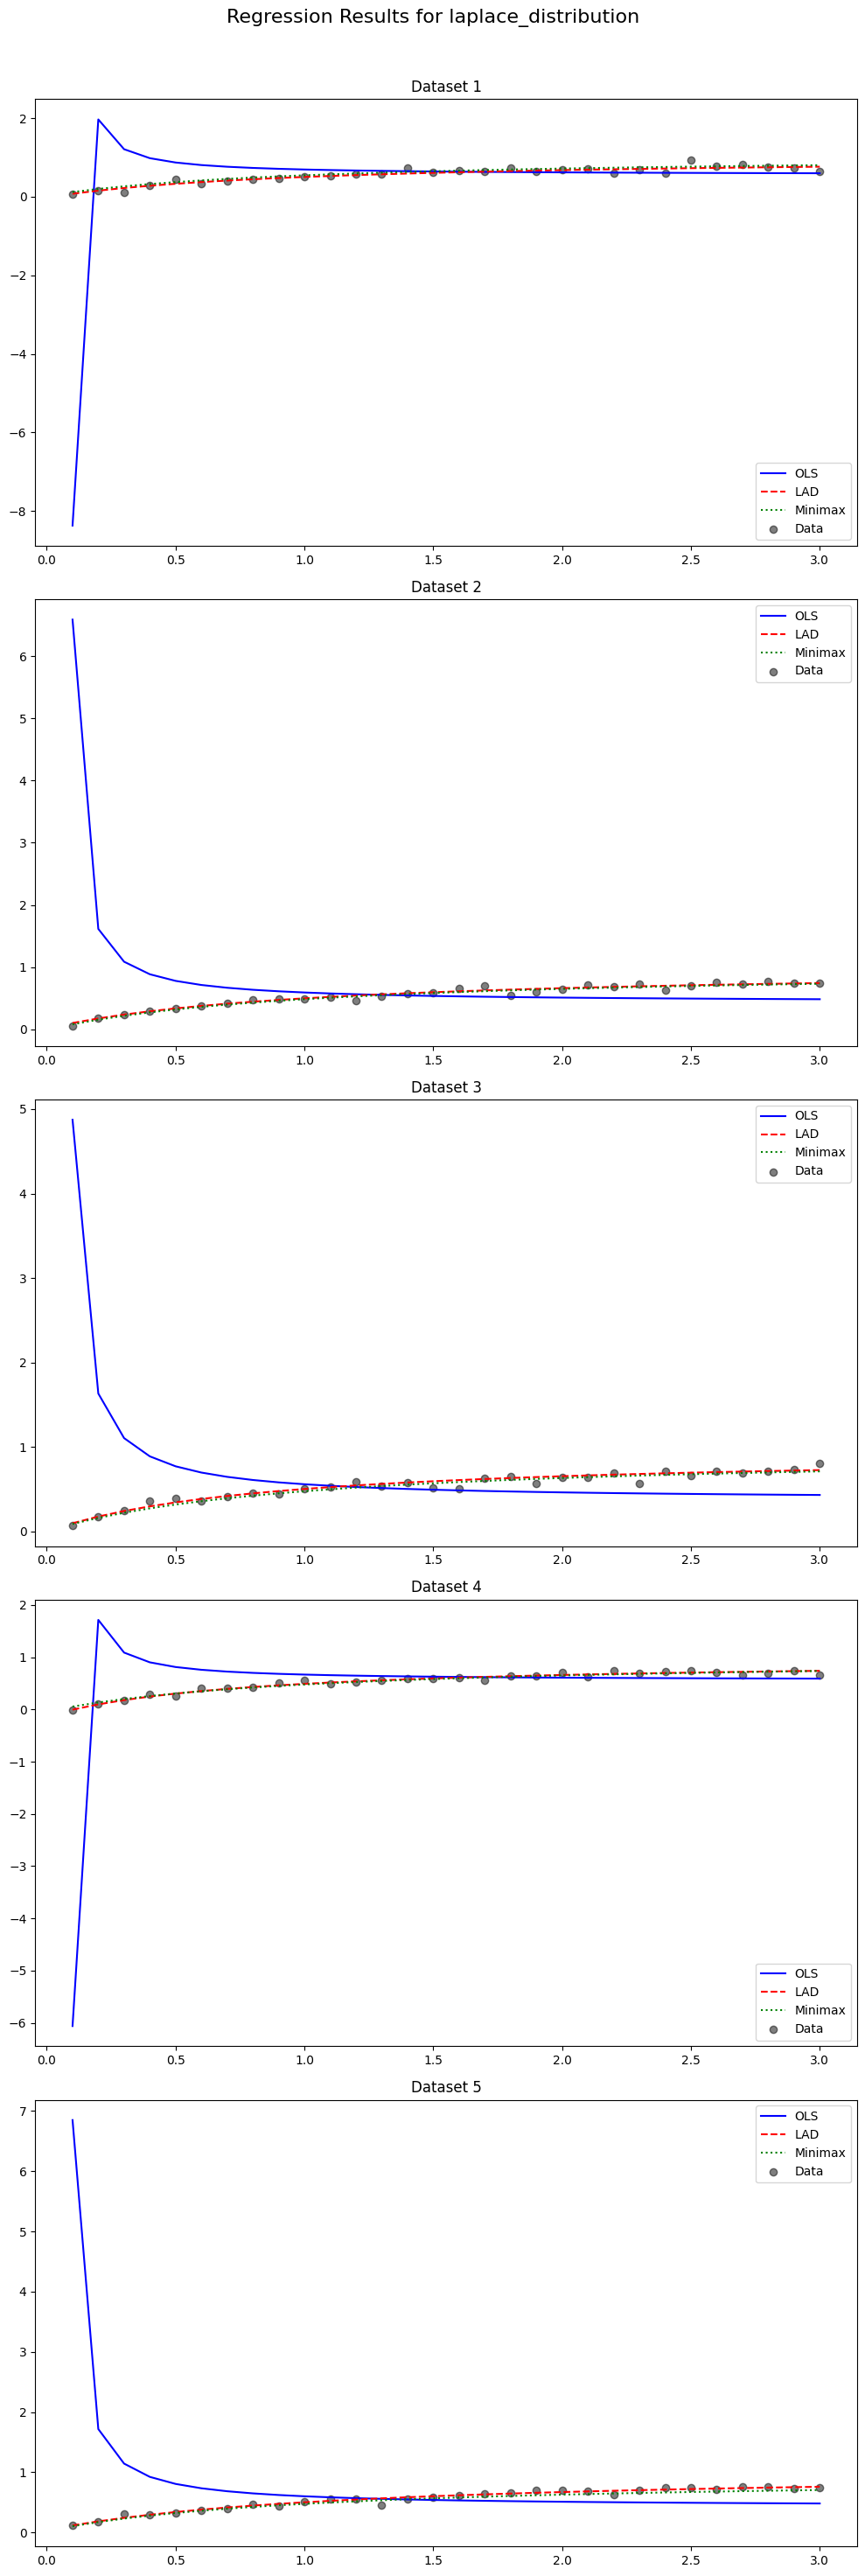

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import laplace, t, f
import numpy.linalg as la
import math
import scipy

# Parameters
N = 10**3  # Number of datasets
x = np.arange(0.1, 3.1, 0.1)
a0 = 0.0
a1 = 1.0
a2 = 1.0

def f(x, a0, a1, a2):
    """The regression function."""
    return (a1 * x + a0) / (x + a2)

sigma = 0.05
lambda_laplace = np.sqrt(2) / sigma


datasets = {
    "normal_distribution": [],
    "uniform_distribution": [],
    "laplace_distribution": [],
}

for _ in range(N):
    #Normal distribution
    epsilon = np.random.normal(0, sigma, len(x))
    y_normal = f(x, a0, a1, a2) + epsilon
    datasets["normal_distribution"].append((x, y_normal))

    #Uniform distribution
    epsilon = np.random.uniform(-np.sqrt(3) * sigma, np.sqrt(3) * sigma, len(x))
    y_uniform = f(x, a0, a1, a2) + epsilon
    datasets["uniform_distribution"].append((x, y_uniform))

    #Laplace distribution
    epsilon = np.random.laplace(0, 1/lambda_laplace, len(x))
    y_laplace = f(x, a0, a1, a2) + epsilon
    datasets["laplace_distribution"].append((x, y_laplace))

def ols_regression(x, y):
    """Ordinary Least Squares regression and test of significance."""
    X = np.vstack((x, np.ones(len(x)), x**2)).T  # Design matrix
    try:
        params = la.solve(X.T @ X, X.T @ y)  # Solve for parameters
        y_predicted = X @ params #Predicted y values

        #Residual sum of squares
        rss = np.sum((y - y_predicted) ** 2)

        #Variance of the error terms
        n = len(x)
        p = 3 #Number of parameters in our regression
        mse = rss/(n - p)

        #Covariance matrix of parameter estimates
        cov_params = np.linalg.inv(X.T @ X) * mse

        #Standard errors of the parameters
        se_a0 = np.sqrt(cov_params[1, 1])
        se_a1 = np.sqrt(cov_params[0, 0])
        se_a2 = np.sqrt(cov_params[2, 2])

        #T-statistics
        t_a0 = params[1] / se_a0
        t_a1 = params[0] / se_a1
        t_a2 = params[2] / se_a2

        #P-values
        p_a0 = 2 * (1 - t.cdf(np.abs(t_a0), n - p))
        p_a1 = 2 * (1 - t.cdf(np.abs(t_a1), n - p))
        p_a2 = 2 * (1 - t.cdf(np.abs(t_a2), n - p))


        return params, p_a0, p_a1, p_a2, mse, y_predicted

    except la.LinAlgError:
        return None, None, None, None, None, None


def lad_regression(x, y):
    """Least Absolute Deviations regression."""
    def objective(params):
        a0, a1, a2 = params
        return np.sum(np.abs(y - f(x, a0, a1, a2)))

    initial_params = [a0, a1, a2]
    result = minimize(objective, initial_params)
    return result.x

def minimax_regression(x, y):
    """Minimax regression."""
    def objective(params):
        a0, a1, a2 = params
        return np.max(np.abs(y - f(x, a0, a1, a2)))

    initial_params = [a0, a1, a2]
    result = minimize(objective, initial_params)
    return result.x


def adequacy_test(y, y_predicted, mse, alpha):
    """Tests the model adequacy"""
    n = len(y)
    p = 3 #Number of parameters in the model

    # Sum of squares of the residuals
    rss = np.sum((y - y_predicted)**2)

    # Degree of freedom for the error
    df_error = n - p

    # Mean squared error
    mse_error = rss/df_error

    #Test statistic
    f_statistic = mse/mse_error

    #P-value
    p_value = 1 - scipy.stats.f.cdf(f_statistic, n - 1, df_error)

    #Adequacy test based on given alpha level
    return p_value < alpha



regression_results = {
    "normal_distribution": {
      "ols": [],
      "lad": [],
      "minimax": [],
      "insignificant_coef_count": [0, 0, 0], #a0, a1, a2 counts respectively
       "inadequate_model_count": 0
      },
    "uniform_distribution":{
      "ols": [],
      "lad": [],
      "minimax": [],
      "insignificant_coef_count": [0, 0, 0],
      "inadequate_model_count": 0
      },
    "laplace_distribution":{
      "ols": [],
      "lad": [],
      "minimax": [],
      "insignificant_coef_count": [0, 0, 0],
      "inadequate_model_count": 0
      }
}


alpha = 0.05
for dist_name, data in datasets.items():
    for x_vals, y_vals in data:
        #OLS Regression
        params, p_a0, p_a1, p_a2, mse, y_predicted = ols_regression(x_vals, y_vals)
        regression_results[dist_name]["ols"].append(params)

        if params is not None: #Check if linear algebra solve worked

            #Insignificant coefficient counts
            if p_a0 is not None and p_a0 > alpha:
                regression_results[dist_name]["insignificant_coef_count"][0] += 1 #increment a0 counter

            if p_a1 is not None and p_a1 > alpha:
               regression_results[dist_name]["insignificant_coef_count"][1] += 1 #increment a1 counter

            if p_a2 is not None and p_a2 > alpha:
               regression_results[dist_name]["insignificant_coef_count"][2] += 1 #increment a2 counter

            #Adequacy test
            if y_predicted is not None and mse is not None and adequacy_test(y_vals, y_predicted, mse, alpha):
                regression_results[dist_name]["inadequate_model_count"] += 1

        #LAD regression
        params = lad_regression(x_vals, y_vals)
        regression_results[dist_name]["lad"].append(params)
        #Minimax regression
        params = minimax_regression(x_vals, y_vals)
        regression_results[dist_name]["minimax"].append(params)

#Calculate results and confidence intervals
confidence_intervals = {}
for dist_name, result in regression_results.items():
    confidence_intervals[dist_name] = {}
    total_samples = N
    for i, count in enumerate(result["insignificant_coef_count"]): #coef results
        p_hat = count / total_samples
        se = np.sqrt((p_hat * (1 - p_hat)) / total_samples) #Standard Error
        lower_bound = max(0, p_hat - 1.96 * se)
        upper_bound = min(1, p_hat + 1.96 * se)
        confidence_intervals[dist_name][f'a{i}']= (lower_bound, upper_bound)

    p_hat = result["inadequate_model_count"] / total_samples
    se = np.sqrt((p_hat * (1 - p_hat)) / total_samples) #Standard Error
    lower_bound = max(0, p_hat - 1.96 * se)
    upper_bound = min(1, p_hat + 1.96 * se)
    confidence_intervals[dist_name]['inadequate_model'] = (lower_bound, upper_bound)


# Result print
for dist_name, result in confidence_intervals.items():
    print(f"\nResults for {dist_name}:")
    for coef_name, ci in result.items():
        print(f"   {coef_name}: {ci}")


# Visualization
num_datasets_to_plot = 5 #Change this to plot more samples. It'll draw N graphs if this variable is equal to N
for dist_name, data in datasets.items():
    fig, axes = plt.subplots(num_datasets_to_plot, 1, figsize=(10, 6 * num_datasets_to_plot))
    fig.suptitle(f"Regression Results for {dist_name}", fontsize=16)

    for i in range(num_datasets_to_plot):
        x_vals, y_vals = data[i]
        #OLS regression plot
        params = regression_results[dist_name]["ols"][i]
        if params is not None: #If OLS worked ok
          y_ols = f(x_vals, params[1], params[0], params[2])
          axes[i].plot(x_vals, y_ols, label="OLS", color = "blue", linestyle = 'solid')
        #LAD regression plot
        params = regression_results[dist_name]["lad"][i]
        y_lad = f(x_vals, params[0], params[1], params[2])
        axes[i].plot(x_vals, y_lad, label="LAD", color = "red", linestyle = 'dashed')
         #Minimax regression plot
        params = regression_results[dist_name]["minimax"][i]
        y_minimax = f(x_vals, params[0], params[1], params[2])
        axes[i].plot(x_vals, y_minimax, label="Minimax", color = "green", linestyle = 'dotted')
        #Data points plot
        axes[i].scatter(x_vals, y_vals, label="Data", color="black", alpha = 0.5) #plotting data
        axes[i].legend()
        axes[i].set_title(f"Dataset {i+1}")

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()